## 1. Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Standard Libraries
from math import sqrt, log

# Data Manipulation & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scikit-learn (Data Preprocessing & Metrics)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, r2_score, mean_absolute_percentage_error

# TensorFlow/Keras (Deep Learning)
import tensorflow as tf
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, Input, Bidirectional
from keras.models import Sequential, Model
from keras import optimizers
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, GRU
from tensorflow.keras import Sequential


## 2. Get Data

In [2]:
# Reading generated power (Solar and wind) data
# Dataset link : https://data.open-power-system-data.org/time_series/2020-10-06

data_path = r"D:\Courses\Graduation project\opsd-time_series-2020-10-06\time_series_60min_singleindex.csv"
kaggle_path = r"../input/wind-and-solar-generation-from-weather-data/time_series_60min_singleindex.csv"

df = pd.read_csv(data_path,
                 usecols=(lambda s: s.startswith('utc') | s.startswith('DE')),
                 parse_dates=[0], index_col=0)

df.head()

,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,...,DE_tennet_load_actual_entsoe_transparency,DE_tennet_load_forecast_entsoe_transparency,DE_tennet_solar_generation_actual,DE_tennet_wind_generation_actual,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_wind_onshore_generation_actual
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,41151.0,39723.0,37248.0,NaN,NaN,27913.0,8852.0,0.3171,667.0,517.0,...,13841.0,13362.0,NaN,3866.0,469.0,3398.0,5307.0,4703.0,NaN,5.0
2015-01-01 01:00:00+00:00,40135.0,38813.0,37248.0,NaN,NaN,27913.0,9054.0,0.3244,667.0,514.0,...,13267.0,12858.0,NaN,3974.0,466.0,3508.0,5087.0,4562.0,NaN,7.0
2015-01-01 02:00:00+00:00,39106.0,38490.0,37248.0,NaN,NaN,27913.0,9070.0,0.3249,667.0,518.0,...,12702.0,12611.0,NaN,4194.0,470.0,3724.0,4906.0,4517.0,NaN,8.0
2015-01-01 03:00:00+00:00,38765.0,38644.0,37248.0,NaN,NaN,27913.0,9163.0,0.3283,667.0,520.0,...,12452.0,12490.0,NaN,4446.0,473.0,3973.0,4865.0,4601.0,NaN,11.0


## 3. Analysis

In [3]:
# As we see in the last two graphs , The wind and solar power aer seasonal  

production_wind_solar = df[['DE_wind_generation_actual', 'DE_solar_generation_actual']]
production_wind_solar.head()

,DE_wind_generation_actual,DE_solar_generation_actual
utc_timestamp,,
2014-12-31 23:00:00+00:00,NaN,NaN
2015-01-01 00:00:00+00:00,8852.0,NaN
2015-01-01 01:00:00+00:00,9054.0,NaN
2015-01-01 02:00:00+00:00,9070.0,NaN
2015-01-01 03:00:00+00:00,9163.0,NaN


In [4]:
# Reading weather data to be combined with power data  
# https://data.open-power-system-data.org/weather_data/2020-09-16
# Metadata link : https://data.open-power-system-data.org/weather_data/2020-09-16/README.md


data_path = r"D:\Courses\Graduation project\opsd-weather_data-2020-09-16\weather_data.csv"
kaggle_path = r"../input/wind-and-solar-generation-from-weather-data/weather_data.csv"

weather = pd.read_csv(data_path, parse_dates=[0], index_col=0)
weather.head()

,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,CH_temperature,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,-6.287,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,-6.602,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,-6.981,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,-7.368,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
1980-01-01 04:00:00+00:00,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,-7.849,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0


In [5]:
# resampling weather data by day to make it ready to be combined with power data  

weather_by_day = weather.groupby(weather.index).mean()
weather_by_day.head()

,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,CH_temperature,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,-6.287,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,-6.602,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,-6.981,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,-7.368,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
1980-01-01 04:00:00+00:00,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,-7.849,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0


In [6]:
# Meging (Solar & wind) data with (weather) data

combined = pd.merge(production_wind_solar, weather_by_day, how='left', left_index=True, right_index=True)
combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,NaN,NaN,-6.495,0.0,0.0,0.100,0.0,0.0,-13.029,0.0,...,0.0,0.610,0.0,0.0,-11.515,0.0,0.0,-8.337,0.0,0.0
2015-01-01 00:00:00+00:00,8852.0,NaN,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,NaN,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,NaN,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,NaN,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0


In [7]:
# Note | we have the solar and wind data from 01/01/2015 to 30/09/2020
#                   and temperature data from 01/01/1980 to 31/12/2019
#                   we should get the intersection between them to be able to create a powerful model
#                   The intersection between them is from 
#                                             01/01/2015 to 31/12/2019

combined = combined.loc[combined.index >= '2015-01-01 00:00:00+00:00', :]
combined = combined.loc[combined.index <= '2019-12-31 23:00:00+00:00', :]

combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,8852.0,NaN,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,NaN,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,NaN,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,NaN,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0
2015-01-01 04:00:00+00:00,9231.0,NaN,-5.516,0.0,0.0,-1.053,0.0,0.0,-14.340,0.0,...,0.0,1.382,0.0,0.0,-10.467,0.0,0.0,-7.399,0.0,0.0


In [8]:
combined.isnull().sum()

DE_wind_generation_actual           74
DE_solar_generation_actual         103
AT_temperature                       0
AT_radiation_direct_horizontal       0
AT_radiation_diffuse_horizontal      0
                                  ... 
SI_radiation_direct_horizontal       0
SI_radiation_diffuse_horizontal      0
SK_temperature                       0
SK_radiation_direct_horizontal       0
SK_radiation_diffuse_horizontal      0
Length: 86, dtype: int64

In [9]:
# There are some nulls found should be filled by the mean of the same column

combined["DE_wind_generation_actual" ].fillna(combined["DE_wind_generation_actual" ].mean(), inplace=True)
combined["DE_solar_generation_actual"].fillna(combined["DE_solar_generation_actual"].mean(), inplace=True)

combined.isnull().sum()

DE_wind_generation_actual          0
DE_solar_generation_actual         0
AT_temperature                     0
AT_radiation_direct_horizontal     0
AT_radiation_diffuse_horizontal    0
                                  ..
SI_radiation_direct_horizontal     0
SI_radiation_diffuse_horizontal    0
SK_temperature                     0
SK_radiation_direct_horizontal     0
SK_radiation_diffuse_horizontal    0
Length: 86, dtype: int64

In [10]:
combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,8852.0,4304.566318,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,4304.566318,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,4304.566318,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,4304.566318,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0
2015-01-01 04:00:00+00:00,9231.0,4304.566318,-5.516,0.0,0.0,-1.053,0.0,0.0,-14.340,0.0,...,0.0,1.382,0.0,0.0,-10.467,0.0,0.0,-7.399,0.0,0.0


In [11]:
# print 20% of columns describtion to take some decisions

(combined.describe().T).iloc[:len(combined)//5 , :]

,count,mean,std,min,25%,50%,75%,max
DE_wind_generation_actual,43824.0,11157.555246,8686.794878,135.000,4427.75000,8745.00000,15562.250000,45085.0000
DE_solar_generation_actual,43824.0,4304.566318,6596.092670,0.000,0.00000,133.00000,6800.000000,30028.0000
AT_temperature,43824.0,8.838494,8.987517,-17.596,1.60050,8.37050,15.812250,32.6310
AT_radiation_direct_horizontal,43824.0,96.426485,179.350207,0.000,0.00000,0.53195,102.667175,869.7446
AT_radiation_diffuse_horizontal,43824.0,65.699744,89.225189,0.000,0.00000,6.95685,110.968725,403.6032
...,...,...,...,...,...,...,...,...
SI_radiation_direct_horizontal,43824.0,105.012554,194.184928,0.000,0.00000,0.40245,111.641525,895.3888
SI_radiation_diffuse_horizontal,43824.0,62.224003,85.819809,0.000,0.00000,6.22485,101.779950,408.4686
SK_temperature,43824.0,9.290873,9.742131,-18.937,1.33975,8.95250,16.948500,35.3110
SK_radiation_direct_horizontal,43824.0,97.754655,182.522103,0.000,0.00000,0.41320,101.175125,878.9789


## 4. Visualization

<Axes: >

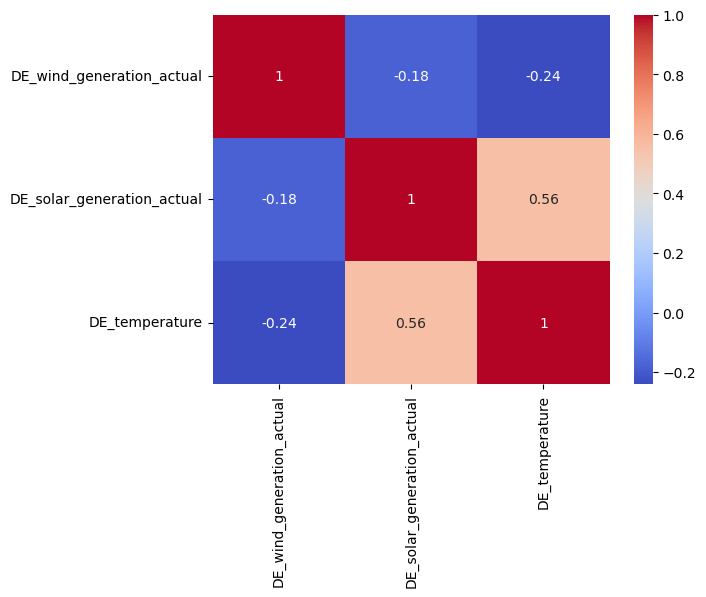

In [12]:
corr_matrix = combined[['DE_wind_generation_actual', 'DE_solar_generation_actual', 'DE_temperature']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

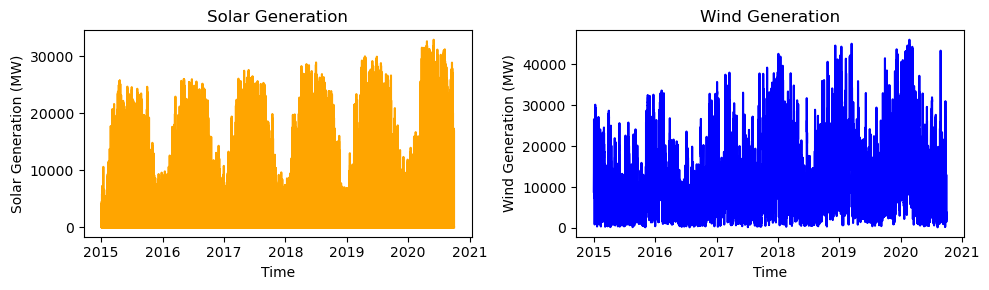

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot the actual solar generation on the first subplot
axs[0].plot(df.index, df['DE_solar_generation_actual'], color='orange')
axs[0].set_title('Solar Generation')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Solar Generation (MW)')

# Plot the actual wind generation on the second subplot
axs[1].plot(df.index, df['DE_wind_generation_actual'], color='blue')
axs[1].set_title('Wind Generation')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Wind Generation (MW)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<Axes: title={'center': 'Wind and Solar Generation Over Time'}, xlabel='utc_timestamp'>

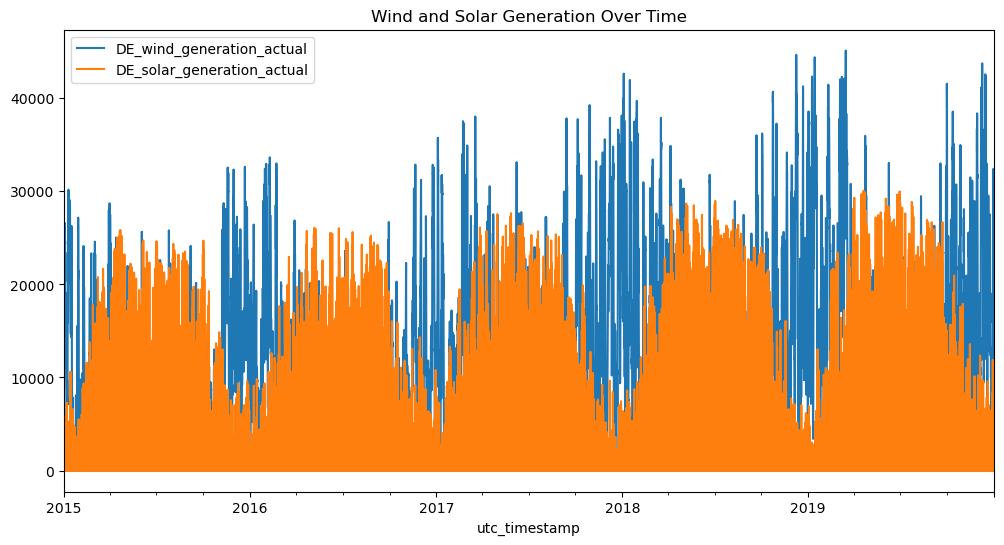

In [14]:
combined[['DE_wind_generation_actual', 'DE_solar_generation_actual']].plot(figsize=(12, 6), title="Wind and Solar Generation Over Time")

<Axes: title={'center': 'Temperature vs Solar Generation'}, xlabel='DE_temperature', ylabel='DE_solar_generation_actual'>

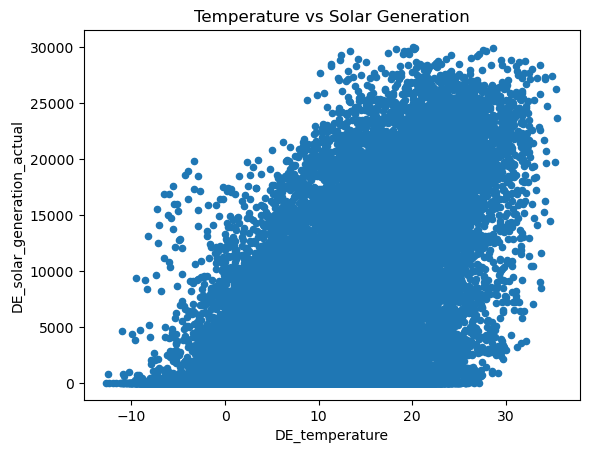

In [15]:
combined.plot.scatter(x='DE_temperature', y='DE_solar_generation_actual', title="Temperature vs Solar Generation")

array([<Axes: xlabel='utc_timestamp'>, <Axes: xlabel='utc_timestamp'>,
       <Axes: xlabel='utc_timestamp'>], dtype=object)

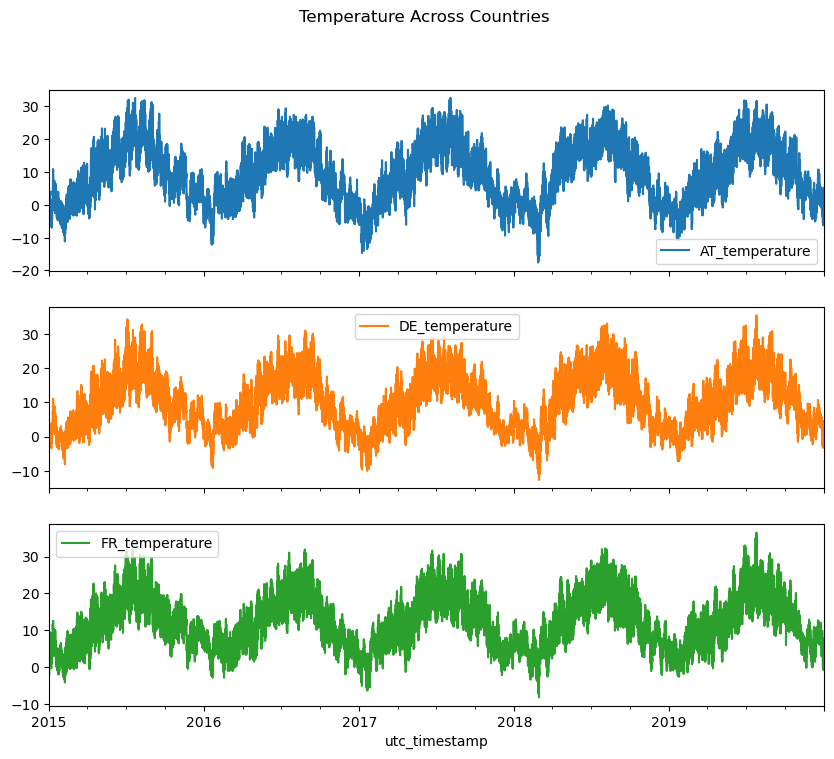

In [16]:
combined[['AT_temperature', 'DE_temperature', 'FR_temperature']].plot(subplots=True, figsize=(10, 8), title="Temperature Across Countries")

### Scaling and Splitting 

In [17]:
X = combined.iloc[:,2:]
y = combined.iloc[:,:2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [18]:
print(f"X_train -> {X_train.shape}")
print(f"y_train -> {y_train.shape}")
print(25 * "-")
print(f"X_test  -> {X_test.shape}")
print(f"y_test  -> {y_test.shape}")

X_train -> (35059, 84)
y_train -> (35059, 2)
-------------------------
X_test  -> (8765, 84)
y_test  -> (8765, 2)


In [19]:
# It is clear that the data should be scaled to make sure that the model will give an accurate result

X_train_scaler = MinMaxScaler().fit(X_train)
X_train = X_train_scaler.transform(X_train)

y_train_scaler = MinMaxScaler().fit(y_train)
y_train = y_train_scaler.transform(y_train)


X_test_scaler = MinMaxScaler().fit(X_test)
X_test = X_test_scaler.transform(X_test)

y_test_scaler = MinMaxScaler().fit(y_test)
y_test = y_train_scaler.transform(y_test)

In [20]:
def root_mean_squared_error(y_true, y_pred):    
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 3)

def evaluation(y_true, y_pred):    
    print("Mean absolute error ----------->", round(mean_absolute_error(y_true.flatten(),y_pred.flatten()), 4))
    # print("Mean squared error ------------>", round(mean_squared_error(y_true.flatten(),y_pred.flatten()), 4))
    print("Root mean squared error ------->", round(sqrt(mean_squared_error(y_true.flatten(),y_pred.flatten())), 4))
    print("Root mean squared log error --->", round(log(sqrt(mean_squared_error(y_true.flatten(),y_pred.flatten()))), 4))
    print("R squared  -------------------->", round(r2_score(y_true.flatten(),y_pred.flatten()), 4))

## 5. Modeling 

### 5.1 DNN

In [21]:
model = Sequential()

model.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(15, activation='relu'))
model.add(Dense(2))

model.compile(optimizer='adam', loss='mse')

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 30)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │             465 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              32 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,047 (11.90 KB)

 Trainable params: 3,047 (11.90 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(X_train, 
                    y_train, 
                    epochs= 50, 
                    verbose= 2,
                    # batch_size= 5000, 
                    validation_split=0.3, 
                    callbacks = callback)

Epoch 1/50
767/767 - 3s - 3ms/step - loss: 0.0206 - val_loss: 0.0160
Epoch 2/50
767/767 - 1s - 1ms/step - loss: 0.0157 - val_loss: 0.0142
Epoch 3/50
767/767 - 1s - 1ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 4/50
767/767 - 1s - 1ms/step - loss: 0.0137 - val_loss: 0.0134
Epoch 5/50
767/767 - 1s - 1ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 6/50
767/767 - 1s - 1ms/step - loss: 0.0127 - val_loss: 0.0123
Epoch 7/50
767/767 - 1s - 1ms/step - loss: 0.0125 - val_loss: 0.0121
Epoch 8/50
767/767 - 1s - 1ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 9/50
767/767 - 1s - 1ms/step - loss: 0.0121 - val_loss: 0.0124
Epoch 10/50
767/767 - 1s - 1ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 11/50
767/767 - 1s - 1ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 12/50
767/767 - 1s - 1ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 13/50
767/767 - 1s - 1ms/step - loss: 0.0115 - val_loss: 0.0113
Epoch 14/50
767/767 - 1s - 1ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 15/50
767/767 - 1s - 1m

In [23]:
y_pred = model.predict(X_test)

print(f"y_test  -> {y_test.shape}")
print(f"y_pred  -> {y_pred.shape}")

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
y_test  -> (8765, 2)
y_pred  -> (8765, 2)


In [24]:
train_results = model.evaluate(X_train, y_train)
test_results  = model.evaluate(X_test, y_test)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - loss: 0.0093
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0098
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [25]:
print("*" * 56)
print(" Train ".center(56,"-"))
print("*" * 56)

evaluation(y_train.flatten(), y_pred_train.flatten())

print("\n","*" * 56,sep="")
print(" Test ".center(56,"-"))
print("*" * 56)

evaluation(y_test.flatten(), y_pred_test.flatten())

********************************************************
------------------------ Train -------------------------
********************************************************
Mean absolute error -----------> 0.0611
Root mean squared error -------> 0.097
Root mean squared log error ---> -2.3329
R squared  --------------------> 0.7935

********************************************************
------------------------- Test -------------------------
********************************************************
Mean absolute error -----------> 0.0622
Root mean squared error -------> 0.0987
Root mean squared log error ---> -2.3161
R squared  --------------------> 0.7826


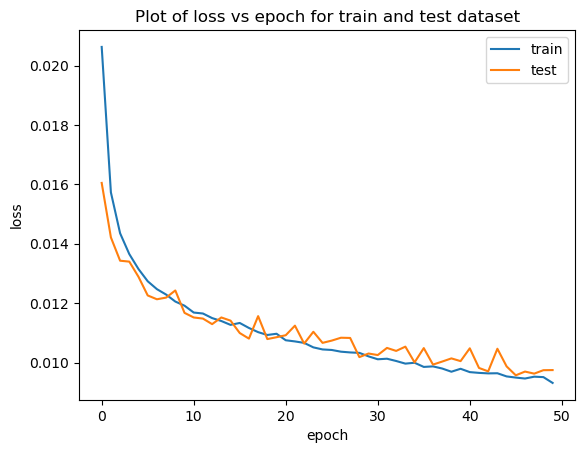

In [26]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### 5.2 LSTM (Stacked)

In [27]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test .reshape(X_test .shape[0], X_test .shape[1], 1)

In [28]:
model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Optional Dropout layer to reduce overfitting

model.add(Dense(20, activation='relu'))
model.add(Dense(2))

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,462 (44.77 KB)

 Trainable params: 11,462 (44.77 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(X_train, 
                    y_train, 
                    epochs= 30, 
                    verbose= 1,
                    # batch_size= 128,
                    validation_split= 0.3, 
                    callbacks= callback)

Epoch 1/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0291 - val_loss: 0.0197
Epoch 2/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0245 - val_loss: 0.0208
Epoch 3/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0214 - val_loss: 0.0199
Epoch 4/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0200 - val_loss: 0.0201
Epoch 5/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0224 - val_loss: 0.0209
Epoch 6/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0212 - val_loss: 0.0201
Epoch 7/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0221 - val_loss: 0.0208
Epoch 8/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0210 - val_loss: 0.0210
Epoch 9/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0220 - val_loss: 0.0207


In [30]:
train_results = model.evaluate(X_train, y_train)
test_results  = model.evaluate(X_test, y_test)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0210
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0206
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [31]:
print("*" * 56)
print(" Train ".center(56,"-"))
print("*" * 56)

evaluation(y_train.flatten(), y_pred_train.flatten())

print("\n","*" * 56,sep="")
print(" Test ".center(56,"-"))
print("*" * 56)

evaluation(y_test.flatten(), y_pred_test.flatten())

********************************************************
------------------------ Train -------------------------
********************************************************
Mean absolute error -----------> 0.0947
Root mean squared error -------> 0.1447
Root mean squared log error ---> -1.9332
R squared  --------------------> 0.5408

********************************************************
------------------------- Test -------------------------
********************************************************
Mean absolute error -----------> 0.0946
Root mean squared error -------> 0.1437
Root mean squared log error ---> -1.9402
R squared  --------------------> 0.539


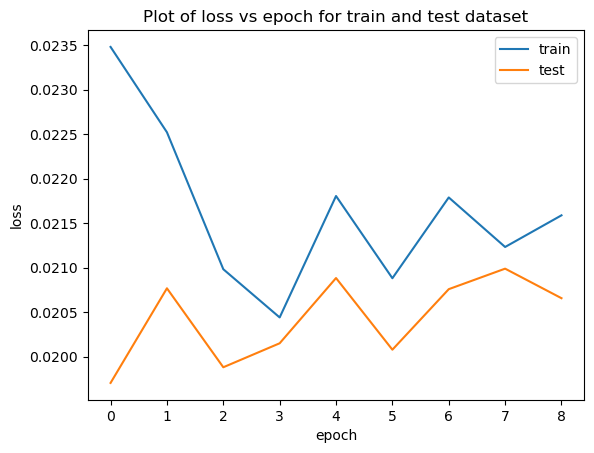

In [32]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### 5.3 CNN

In [33]:
model = Sequential()

model.add(Conv1D(32, 3, padding="same",input_shape = (X_train.shape[1], 1), activation='relu'))
model.add(MaxPool1D(pool_size=(4)))  
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same", activation='relu'))
model.add(MaxPool1D(pool_size=(4)))  
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=50))
model.add(Dense(units=2))

model.compile(loss='mse', optimizer='adam')

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 84, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 21, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 21, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 5, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │           8,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,384 (44.47 KB)

 Trainable params: 11,384 (44.47 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history = model.fit(X_train, 
                    y_train, 
                    epochs= 30, 
                    verbose= 1,
                    # batch_size= 128,
                    validation_split=0.3, 
                    callbacks= callback)

Epoch 1/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0253 - val_loss: 0.0194
Epoch 2/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0188 - val_loss: 0.0173
Epoch 3/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0187 - val_loss: 0.0168
Epoch 4/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0180 - val_loss: 0.0175
Epoch 5/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0178 - val_loss: 0.0165
Epoch 6/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0174 - val_loss: 0.0158
Epoch 7/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0171 - val_loss: 0.0164
Epoch 8/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0167 - val_loss: 0.0153
Epoch 9/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0167 - val_loss: 0.0159
Epoch 10/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0166 - val_loss: 0.0152
Epoch 11/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0163 - val_loss: 0.0152
Epoch 12/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

In [35]:
train_results = model.evaluate(X_train, y_train)
test_results  = model.evaluate(X_test, y_test)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0142
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [36]:
print("*" * 56)
print(" Train ".center(56,"-"))
print("*" * 56)

evaluation(y_train.flatten(), y_pred_train.flatten())

print("\n","*" * 56,sep="")
print(" Test ".center(56,"-"))
print("*" * 56)

evaluation(y_test.flatten(), y_pred_test.flatten())

********************************************************
------------------------ Train -------------------------
********************************************************
Mean absolute error -----------> 0.0793
Root mean squared error -------> 0.1195
Root mean squared log error ---> -2.1242
R squared  --------------------> 0.6866

********************************************************
------------------------- Test -------------------------
********************************************************
Mean absolute error -----------> 0.08
Root mean squared error -------> 0.1203
Root mean squared log error ---> -2.1176
R squared  --------------------> 0.6766


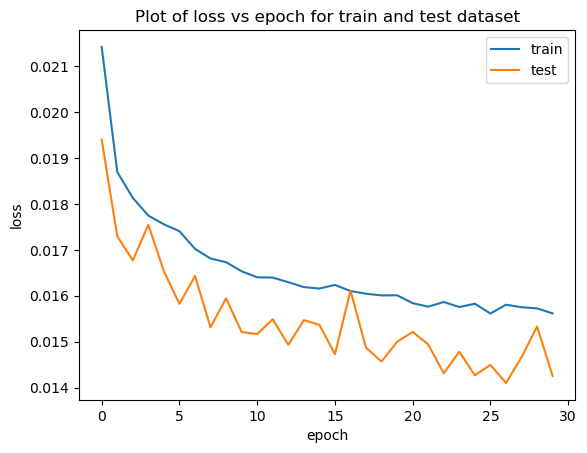

In [37]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### 5.4 GRU

In [38]:
model = Sequential()

# GRU expects 3D input
model.add(GRU(64, activation='tanh', input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(32, activation='tanh', return_sequences=False))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(2))

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Display the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 84, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 84, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,624 (88.38 KB)

 Trainable params: 22,624 (88.38 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(X_train, 
                    y_train, 
                    epochs= 30, 
                    verbose= 1,
                    # batch_size= 128,
                    validation_split=0.3, 
                    callbacks= callback)

Epoch 1/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 53s 63ms/step - loss: 0.0285 - val_loss: 0.0208
Epoch 2/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - loss: 0.0215 - val_loss: 0.0205
Epoch 3/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - loss: 0.0205 - val_loss: 0.0195
Epoch 4/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - loss: 0.0205 - val_loss: 0.0190
Epoch 5/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - loss: 0.0198 - val_loss: 0.0193
Epoch 6/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - loss: 0.0194 - val_loss: 0.0182
Epoch 7/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - loss: 0.0186 - val_loss: 0.0175
Epoch 8/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - loss: 0.0181 - val_loss: 0.0173
Epoch 9/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - loss: 0.0176 - val_loss: 0.0162
Epoch 10/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - loss: 0.0166 - val_loss: 0.0153
Epoch 11/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - loss: 0.0159 - val_loss: 0.0150
Epoch 12/30
767/767 ━━━━━━━━━━

In [40]:
train_results = model.evaluate(X_train, y_train)
test_results  = model.evaluate(X_test, y_test)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0116
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0130
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


In [41]:
print("*" * 56)
print(" Train ".center(56,"-"))
print("*" * 56)

evaluation(y_train.flatten(), y_pred_train.flatten())

print("\n","*" * 56,sep="")
print(" Test ".center(56,"-"))
print("*" * 56)

evaluation(y_test.flatten(), y_pred_test.flatten())

********************************************************
------------------------ Train -------------------------
********************************************************
Mean absolute error -----------> 0.069
Root mean squared error -------> 0.1087
Root mean squared log error ---> -2.2193
R squared  --------------------> 0.7409

********************************************************
------------------------- Test -------------------------
********************************************************
Mean absolute error -----------> 0.0715
Root mean squared error -------> 0.1132
Root mean squared log error ---> -2.1786
R squared  --------------------> 0.7138


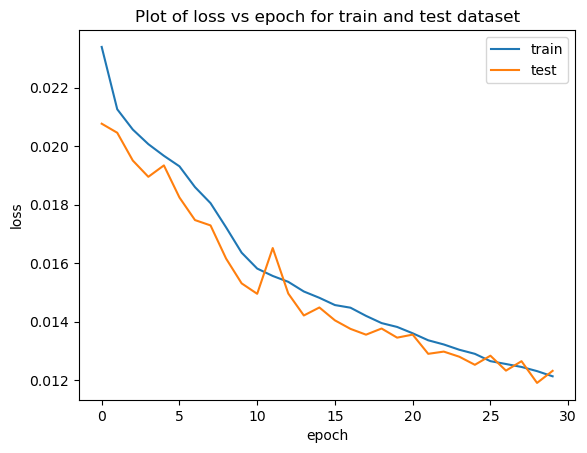

In [42]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()